
## <code style="color:steelblue">Student Name: Zheyuan Dong</code>

#### COMPANION WORKBOOK

# Cluster Analysis

This module does not have a separate Coding Section. Instead, we will be using the exercises below to run all mission-critical code.

At last, it's time to build our clustering models! Remember, for clustering problems, the chosen input features are usually more important than which algorithm you use.
* In this module, we'll apply the K-Means algorithm to 3 different feature sets.
* There are no clear, widely-accepted performance metrics for clusters because there're no "ground truth" labels.
* Even so, we can compare the different clusters created from the 3 different feature sets.

#### First, let's import libraries we'll need for data cleaning and feature engineering.

In general, it's good practice to keep all of your library imports at the top of your notebook or program. **Tip:** If you forget one, you can always add it here later and re-run this code block.

We've provided comments for guidance.

In [1]:
# Importing the packages 

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format',lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns 
sns.set_style('darkgrid')

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import pickle
import warnings 
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)



#### Next, read in the 3 CSV files we've saved throughout this project.
* Let's read in <code style="color:crimson">'analytical_base_table.csv'</code> (created in Module 1) as <code style="color:steelblue">base_df</code>. 
* Let's read in <code style="color:crimson">'threshold_item_data.csv'</code> (created in Module 2) as <code style="color:steelblue">threshold_item_data</code>. 
* Let's read in <code style="color:crimson">'pca_item_data.csv'</code> (created in Module 3) as <code style="color:steelblue">pca_item_data</code>. 
* Set <code style="color:steelblue">index_col=0</code> for each one to use CustomerID as the index.

In [2]:
base_df = pd.read_csv('analytical_base_table.csv')
base_df.rename(columns= {'CustomerID': 'customer'}, inplace=True)
base_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300


In [3]:
threshold_item_data = pd.read_csv('threshold_item_data.csv')
threshold_item_data.head()

,customer,POST,22326,22423,22554,22556,21731,22328,22629,22551,21212,20725,23084,20750,20719,85099B,20726,21080,22139,22630,22961
0,12347,0,0,4,0,0,5,0,0,0,0,0,3,0,4,0,0,0,0,0,0
1,12348,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12349,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12350,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12352,5,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [4]:
pca_item_data = pd.read_csv('pca_item_data.csv')
pca_item_data.head()

,customer,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
0,12347,5.876,4.829,-0.496,3.094,-0.634,-11.534,2.162,7.117,5.336,4.424,4.637,2.317,12.311,1.987,-11.431,5.618,-2.177,7.666,-12.136,-16.048,-5.950,7.815,40.516,-35.575,-17.557,6.870,20.888,2.297,-26.156,-32.582,7.884,12.354,6.832,-32.956,-4.408,-17.235,-11.275,-14.490,-2.764,4.735,-6.985,-1.461,10.600,1.242,3.096,5.332,-0.417,1.527,-6.409,...,2.312,2.528,-1.020,-1.827,-1.782,1.251,0.268,-1.713,1.675,-3.595,0.525,-1.874,0.624,0.238,1.120,-1.801,0.666,0.234,-0.150,0.843,-0.364,-0.573,-0.062,0.622,0.037,-0.811,1.602,0.104,-0.153,-0.251,0.411,-0.486,-0.138,1.202,0.414,0.565,-0.655,1.073,-0.057,0.240,-0.008,-0.779,0.613,-0.331,-0.005,-0.046,0.148,-0.062,-0.199,-0.269
1,12348,-4.220,1.226,-1.882,-0.174,0.818,1.161,-0.872,-0.847,0.460,0.854,-0.402,0.982,-1.104,0.770,-0.093,-0.313,-0.449,1.208,0.382,-0.469,0.184,0.054,0.501,0.374,1.226,-0.772,-0.270,0.851,-0.371,-0.578,1.010,-0.583,0.946,-0.736,0.356,-0.385,-0.297,0.397,0.153,0.334,-0.458,0.707,1.213,-0.199,-0.862,-0.067,-0.417,-1.614,-0.364,...,-1.004,-0.889,-0.531,-0.277,0.036,0.130,-0.561,-0.395,-0.630,0.320,0.237,0.149,-1.854,0.125,-0.417,-0.742,0.208,0.995,-0.156,1.088,0.081,0.413,1.287,1.003,-0.653,0.791,-0.721,-0.458,-1.723,-1.502,1.066,-0.697,2.012,-0.602,-0.767,-0.246,0.569,-0.933,1.556,-1.138,-1.904,0.076,-0.956,1.410,0.724,0.465,1.908,-1.417,1.121,-2.947
2,12349,-1.261,2.388,-0.073,-1.119,-0.035,-3.715,-0.343,-0.149,-0.790,-0.378,1.568,0.182,0.222,-0.050,3.180,-0.514,-1.839,0.383,0.318,-0.006,-0.414,0.457,-0.789,1.755,-1.483,0.752,-0.918,0.767,0.488,-1.349,0.288,0.645,0.070,-0.219,-0.668,-1.541,0.791,-1.412,-0.093,-0.923,0.076,-0.098,-0.162,0.704,1.398,-0.256,-0.132,-0.194,0.844,...,2.025,-0.915,1.982,0.634,0.648,0.192,-1.110,1.053,-1.183,-0.545,1.395,1.571,-2.602,-2.140,1.168,-2.044,-2.058,-2.018,-1.913,-1.861,-0.138,-1.027,1.864,0.085,0.376,1.989,-1.387,-1.451,2.877,-1.126,-0.047,-2.985,2.004,0.914,-1.002,-0.013,2.621,-2.023,-0.627,0.658,4.596,-4.528,-2.371,-3.396,-3.419,-1.305,3.846,0.808,-4.653,2.595
3,12350,-4.929,-0.715,-1.581,-0.470,-0.116,0.648,0.113,-1.336,1.547,-1.191,-0.213,1.057,-0.475,0.857,-1.305,0.243,0.269,1.954,-0.229,0.572,-0.186,0.904,1.363,0.176,-0.262,-0.165,-0.683,1.081,-0.153,-0.398,0.240,0.632,-1.450,-0.182,-0.316,-0.307,-1.360,-0.004,0.585,-0.251,0.590,-0.216,0.283,0.514,-0.522,-0.102,-1.469,0.153,0.138,...,1.588,-0.313,0.538,0.498,-0.379,-0.143,-1.632,0.266,-0.821,0.066,0.353,-0.099,-0.238,-0.239,-0.616,0.136,0.128,-0.328,-0.031,0.925,0.700,-0.470,-0.466,-0.425,-0.414,-0.476,-0.073,0.003,-0.307,0.746,-0.098,0.009,-0.942,-0.972,0.089,-0.500,-0.878,-0.115,-0.947,-0.832,-1.870,-0.460,-1.192,-0.597,-0.809,0.374,-0.283,-0.819,-1.010,0.363
4,12352,-2.053,2.111,0.185,0.128,0.087,-1.943,2.383,0.898,-0.673,0.081,0.877,1.050,-0.741,-2.072,-0.638,0.017,0.117,0.575,-0.028,0.106,-0.698,-0.913,-2.333,0.520,-1.753,0.220,-1.066,-1.803,-0.926,2.093,-0.158,2.225,2.248,-0.582,2.444,1.382,0.197,-0.415,1.808,1.221,-0.947,-0.870,-1.125,-0.088,-0.881,-2.234,-1.615,-1.445,0.990,...,1.293,-0.148,2.529,-3.247,0.605,0.354,-0.785,2.509,0.009,-2.355,-2.510,2.113,0.605,-5.851,-1.172,-4.393,-4.342,-0.346,-1.995,-6.939,-1.358,-0.772,-5.747,5.446,5.885,-4.315,12.602,-1.298,8.606,0.545,19.256,2.775,-9.282,-4.182,5.704,15.601,-12.005,6.063,1.766,-0.423,1.696,8.096,10.326,-8.947,-3.583,-2.078,3.346,5.184,0.928,-1.933


#### <span style="color:#555">EXERCISES</span>

Complete each of the following exercises.

## <span style="color:RoyalBlue">Exercise 5.1 - Feature Sets</span>

Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.** 

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features (**"Base DF"**)
* Purchase pattern features + item features chosen by thresholding (**"Threshold DF"**)
* Purchase pattern features + principal component features from items (**"PCA DF"**)

Before moving on, let's create those feature sets.

#### A.) First, print the shape of each the dataframes you read in above, just to make sure we're on the same page.
* We should have 8 features for our analytical base table. These are the customer-level purchase pattern features.
* We should have 20 features for thresholded item features. These are the number of times a customer purchased each of the top 20 most popular items.
* We should have 125 features for the PCA item features. These are the first 125 principal component features, ordered by explained variance.

In [5]:
for df in [base_df, threshold_item_data, pca_item_data]:
    print(df.shape)

(414, 9)
(414, 21)
(414, 126)


We already have a <code style="color:steelblue">base_df</code>.

#### B.) Next, create a <code style="color:steelblue">threshold_df</code> by joining the <code style="color:steelblue">base_df</code> with <code style="color:steelblue">threshold_item_data</code>.
* Then, display the first 5 rows of the new dataframe.

In [6]:
threshold_df = base_df.merge(threshold_item_data, how='left', on= 'customer')
threshold_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,POST,22326,22423,22554,22556,21731,22328,22629,22551,21212,20725,23084,20750,20719,85099B,20726,21080,22139,22630,22961
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320,0,0,4,0,0,5,0,0,0,0,0,3,0,4,0,0,0,0,0,0
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300,5,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### C.) Finally, create a <code style="color:steelblue">pca_df</code> by joining <code style="color:steelblue">base_df</code> with <code style="color:steelblue">pca_item_data</code>.
* Then, display the first 5 rows of the new dataframe.

In [7]:
pca_df = base_df.merge(pca_item_data, how='left', on= 'customer')
pca_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320,5.876,4.829,-0.496,3.094,-0.634,-11.534,2.162,7.117,5.336,4.424,4.637,2.317,12.311,1.987,-11.431,5.618,-2.177,7.666,-12.136,-16.048,-5.950,7.815,40.516,-35.575,-17.557,6.870,20.888,2.297,-26.156,-32.582,7.884,12.354,6.832,-32.956,-4.408,-17.235,-11.275,-14.490,-2.764,4.735,-6.985,...,2.312,2.528,-1.020,-1.827,-1.782,1.251,0.268,-1.713,1.675,-3.595,0.525,-1.874,0.624,0.238,1.120,-1.801,0.666,0.234,-0.150,0.843,-0.364,-0.573,-0.062,0.622,0.037,-0.811,1.602,0.104,-0.153,-0.251,0.411,-0.486,-0.138,1.202,0.414,0.565,-0.655,1.073,-0.057,0.240,-0.008,-0.779,0.613,-0.331,-0.005,-0.046,0.148,-0.062,-0.199,-0.269
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800,-4.220,1.226,-1.882,-0.174,0.818,1.161,-0.872,-0.847,0.460,0.854,-0.402,0.982,-1.104,0.770,-0.093,-0.313,-0.449,1.208,0.382,-0.469,0.184,0.054,0.501,0.374,1.226,-0.772,-0.270,0.851,-0.371,-0.578,1.010,-0.583,0.946,-0.736,0.356,-0.385,-0.297,0.397,0.153,0.334,-0.458,...,-1.004,-0.889,-0.531,-0.277,0.036,0.130,-0.561,-0.395,-0.630,0.320,0.237,0.149,-1.854,0.125,-0.417,-0.742,0.208,0.995,-0.156,1.088,0.081,0.413,1.287,1.003,-0.653,0.791,-0.721,-0.458,-1.723,-1.502,1.066,-0.697,2.012,-0.602,-0.767,-0.246,0.569,-0.933,1.556,-1.138,-1.904,0.076,-0.956,1.410,0.724,0.465,1.908,-1.417,1.121,-2.947
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550,-1.261,2.388,-0.073,-1.119,-0.035,-3.715,-0.343,-0.149,-0.790,-0.378,1.568,0.182,0.222,-0.050,3.180,-0.514,-1.839,0.383,0.318,-0.006,-0.414,0.457,-0.789,1.755,-1.483,0.752,-0.918,0.767,0.488,-1.349,0.288,0.645,0.070,-0.219,-0.668,-1.541,0.791,-1.412,-0.093,-0.923,0.076,...,2.025,-0.915,1.982,0.634,0.648,0.192,-1.110,1.053,-1.183,-0.545,1.395,1.571,-2.602,-2.140,1.168,-2.044,-2.058,-2.018,-1.913,-1.861,-0.138,-1.027,1.864,0.085,0.376,1.989,-1.387,-1.451,2.877,-1.126,-0.047,-2.985,2.004,0.914,-1.002,-0.013,2.621,-2.023,-0.627,0.658,4.596,-4.528,-2.371,-3.396,-3.419,-1.305,3.846,0.808,-4.653,2.595
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400,-4.929,-0.715,-1.581,-0.470,-0.116,0.648,0.113,-1.336,1.547,-1.191,-0.213,1.057,-0.475,0.857,-1.305,0.243,0.269,1.954,-0.229,0.572,-0.186,0.904,1.363,0.176,-0.262,-0.165,-0.683,1.081,-0.153,-0.398,0.240,0.632,-1.450,-0.182,-0.316,-0.307,-1.360,-0.004,0.585,-0.251,0.590,...,1.588,-0.313,0.538,0.498,-0.379,-0.143,-1.632,0.266,-0.821,0.066,0.353,-0.099,-0.238,-0.239,-0.616,0.136,0.128,-0.328,-0.031,0.925,0.700,-0.470,-0.466,-0.425,-0.414,-0.476,-0.073,0.003,-0.307,0.746,-0.098,0.009,-0.942,-0.972,0.089,-0.500,-0.878,-0.115,-0.947,-0.832,-1.870,-0.460,-1.192,-0.597,-0.809,0.374,-0.283,-0.819,-1.010,0.363
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300,-2.053,2.111,0.185,0.128,0.087,-1.943,2.383,0.898,-0.673,0.081,0.877,1.050,-0.741,-2.072,-0.638,0.017,0.117,0.575,-0.028,0.106,-0.698,-0.913,-2.333,0.520,-1.753,0.220,-1.066,-1.803,-0.926,2.093,-0.158,2.225,2.248,-0.582,2.444,1.382,0.197,-0.415,1.808,1.221,-0.947,...,1.293,-0.148,2.529,-3.247,0.605,0.354,-0.785,2.509,0.009,-2.355,-2.510,2.113,0.605,-5.851,-1.172,-4.393,-4.342,-0.346,-1.995,-6.939,-1.358,-0.772,-5.747,5.446,5.885,-4.315,12.602,-1.298,8.606,0.545,19.256,2.775,-9.282,-4.182,5.704,15.601,-12.005,6.063,1.766,-0.423,1.696,8.096,10.326,-8.947,-3.583,-2.078,3.346,5.184,0.928,-1.933


## <span style="color:RoyalBlue">Exercise 5.2 - Base DF Clustering</span>

Now that we have our 3 candidate feature sets and the K-Means algorithm imported, we're ready to start making clusters! The first set of features we'll consider is **"Base DF"**. This only includes the purchase pattern features from our analytical base table.

So, **how many clusters** should you set?
* As with much of Unsupervised Learning, there's no right or wrong answer.
* Typically, you should consider how your client/key stakeholder will use the clusters.
* For example, let's say our client, the online gift retailer, employs 3 customer service reps, and they want to assign one cluster to each rep.
* In that case, the obvious answer is 3.

For this project, we'll set the number of clusters to 3. However, you should always feel free to adapt this number depending on what you need.

#### A.) Before moving on, make sure this import is in your imports section above. Then, re-run that code cell if needed.

<pre style="color:steelblue">
from sklearn.cluster import KMeans
</pre>

#### B.) First, display the first 5 observations from <code style="color:steelblue">base_df</code> just as reminder.

In [8]:
from sklearn.cluster import KMeans

In [9]:
base_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300


Next, just as we did in the previous 2 projects, let's create a **model pipeline**.
* Remember, K-Means calculates clusters based on distances.
* We wouldn't want a large feature (with large variances) to dominate our algorithm.
* Therefore, we should **scale** our features before fitting the model.

#### C.) Initialize a model pipeline for K-Means.
* Remember that you can control the number of clusters using <code style="color:steelblue">n_clusters=3</code>. This is the hyperparameter $k$ (as in "k"-means).
* Let's also set <code style="color:steelblue">random_state=123</code> for replicable results. 

In [10]:
pipeline= make_pipeline(StandardScaler(), 
    KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))

#### D.) Now that you have the pipeline, go ahead and fit a K-Means model on Base DF.

In [11]:
X = base_df.iloc[:, 1:]
pipeline.fit(X)

c:\Users\Damie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
c:\Users\Damie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans',
                 KMeans(n_clusters=3, n_jobs=1, precompute_distances='auto',
                        random_state=123))])

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0))])
</pre>

#### E.) Finally, call <code style="color:steelblue">.predict()</code> on the dataset to get the clusters.
* Save the clusters as a new column in the Base DF.
* Display the first 5 rows of the Base DF (note the new 'cluster' column below).

In [12]:
clusters = pipeline.predict(X)
base_df['cluster'] = clusters
base_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,cluster
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320,2
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800,0
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550,0
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400,0
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300,0


If you look/scroll over to the right, you can see the new <code style="color:steelblue">'cluster'</code> column that has the cluster that each customer was assigned to. Since we set $k=3$, the possible values will be <code style="color:crimson">0</code>, <code style="color:crimson">1</code>, or <code style="color:crimson">2</code>.

#### F.) Plot a scatterplot of total sales vs. average cart value, and color the points by cluster.
* Since it's impossible to visualize all of the features, we'll just pick 2.
* Remember, you can use the <code style="color:steelblue">hue=</code> argument to color by cluster when using Seaborn's <code style="color:steelblue">.lmplot()</code>.

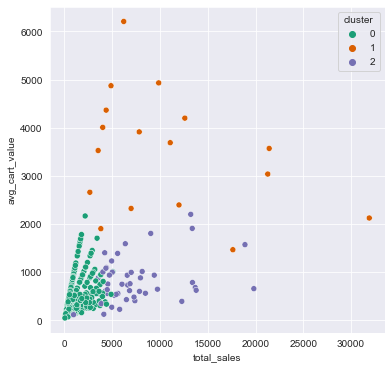

In [13]:
plt.figure(figsize= (6,6))
sns.scatterplot(data= base_df, x='total_sales', y='avg_cart_value', 
    hue='cluster',
    palette= 'Dark2')
plt.show()


## <span style="color:RoyalBlue">Exercise 5.3 - Threshold DF Clustering</span>

The second set of features we'll consider is **"Threshold DF"**. 
* This includes the purchase pattern features from our analytical base table.
* This also includes the purchase counts for the 20 most popular items.

We'll repeat the same steps as above.

#### A.) First, initialize a new model pipeline for K-Means.
* Set it to create 3 clusters.
* Also set <code style="color:steelblue">random_state=123</code> for replicable results. 

In [14]:
pipeline2= make_pipeline(StandardScaler(), 
    KMeans(
    n_clusters=3, 
    random_state=123))

#### B.) Next, fit the K-Means model pipeline to <code style="color:steelblue">threshold_df</code>.

In [15]:
X= threshold_df.iloc[:, 1:]
pipeline2.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

#### C.) Save the predicted clusters to <code style="color:steelblue">threshold_df</code> as a new column.
* Then display the first 5 rows to confirm your code.

In [16]:
clusters= pipeline2.predict(X)
threshold_df['cluster'] = clusters
threshold_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,POST,22326,22423,22554,22556,21731,22328,22629,22551,21212,20725,23084,20750,20719,85099B,20726,21080,22139,22630,22961,cluster
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320,0,0,4,0,0,5,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300,5,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


If you scroll to the right, you'll see the assigned clusters.

#### D.) To visualize these clusters, plot a scatterplot and color the points by cluster.
* Use the same 2 features as in the scatterplot from the previous exercise so that you can visually contrast the plots.
* Use the <code style="color:steelblue">hue=</code> argument to color by cluster.

<AxesSubplot:xlabel='total_sales', ylabel='avg_cart_value'>

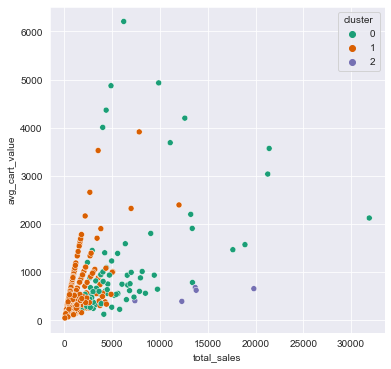

In [17]:
plt.figure(figsize=(6,6))
sns.scatterplot(data= threshold_df, x='total_sales', y='avg_cart_value', 
    hue='cluster',
    palette='Dark2')

## <span style="color:RoyalBlue">Exercise 5.4 - PCA DF Clustering</span>

The last set of features we'll consider is **"PCA DF"**. 
* This includes the purchase pattern features from our analytical base table.
* This also includes the first 125 principal component features from the item data.

We'll repeat the same steps as above.

#### A.) First, initialize a new model pipeline for K-Means.
* Set it to create 3 clusters.
* Also set <code style="color:steelblue">random_state=123</code> for replicable results. 

In [26]:
pipeline3= make_pipeline(StandardScaler(), 
    KMeans(random_state= 321, n_clusters=3))

#### B.) Next, fit the K-Means model pipeline to <code style="color:steelblue">pca_df</code>.

In [27]:
X= pca_df.iloc[:, 1:]
pipeline3.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=321))])

#### C.) Save the clusters to <code style="color:steelblue">pca_df</code>.

In [28]:
clusters= pipeline3.predict(X)
pca_df['cluster']= clusters
pca_df.head()

,customer,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,...,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,cluster
0,12347,7,182,103,4310.000,23.681,615.714,224.820,1294.320,5.876,4.829,-0.496,3.094,-0.634,-11.534,2.162,7.117,5.336,4.424,4.637,2.317,12.311,1.987,-11.431,5.618,-2.177,7.666,-12.136,-16.048,-5.950,7.815,40.516,-35.575,-17.557,6.870,20.888,2.297,-26.156,-32.582,7.884,12.354,6.832,-32.956,-4.408,-17.235,-11.275,-14.490,-2.764,4.735,-6.985,...,2.528,-1.020,-1.827,-1.782,1.251,0.268,-1.713,1.675,-3.595,0.525,-1.874,0.624,0.238,1.120,-1.801,0.666,0.234,-0.150,0.843,-0.364,-0.573,-0.062,0.622,0.037,-0.811,1.602,0.104,-0.153,-0.251,0.411,-0.486,-0.138,1.202,0.414,0.565,-0.655,1.073,-0.057,0.240,-0.008,-0.779,0.613,-0.331,-0.005,-0.046,0.148,-0.062,-0.199,-0.269,0
1,12348,4,31,22,1797.240,57.975,449.310,227.440,892.800,-4.220,1.226,-1.882,-0.174,0.818,1.161,-0.872,-0.847,0.460,0.854,-0.402,0.982,-1.104,0.770,-0.093,-0.313,-0.449,1.208,0.382,-0.469,0.184,0.054,0.501,0.374,1.226,-0.772,-0.270,0.851,-0.371,-0.578,1.010,-0.583,0.946,-0.736,0.356,-0.385,-0.297,0.397,0.153,0.334,-0.458,...,-0.889,-0.531,-0.277,0.036,0.130,-0.561,-0.395,-0.630,0.320,0.237,0.149,-1.854,0.125,-0.417,-0.742,0.208,0.995,-0.156,1.088,0.081,0.413,1.287,1.003,-0.653,0.791,-0.721,-0.458,-1.723,-1.502,1.066,-0.697,2.012,-0.602,-0.767,-0.246,0.569,-0.933,1.556,-1.138,-1.904,0.076,-0.956,1.410,0.724,0.465,1.908,-1.417,1.121,-2.947,0
2,12349,1,73,73,1757.550,24.076,1757.550,1757.550,1757.550,-1.261,2.388,-0.073,-1.119,-0.035,-3.715,-0.343,-0.149,-0.790,-0.378,1.568,0.182,0.222,-0.050,3.180,-0.514,-1.839,0.383,0.318,-0.006,-0.414,0.457,-0.789,1.755,-1.483,0.752,-0.918,0.767,0.488,-1.349,0.288,0.645,0.070,-0.219,-0.668,-1.541,0.791,-1.412,-0.093,-0.923,0.076,...,-0.915,1.982,0.634,0.648,0.192,-1.110,1.053,-1.183,-0.545,1.395,1.571,-2.602,-2.140,1.168,-2.044,-2.058,-2.018,-1.913,-1.861,-0.138,-1.027,1.864,0.085,0.376,1.989,-1.387,-1.451,2.877,-1.126,-0.047,-2.985,2.004,0.914,-1.002,-0.013,2.621,-2.023,-0.627,0.658,4.596,-4.528,-2.371,-3.396,-3.419,-1.305,3.846,0.808,-4.653,2.595,0
3,12350,1,17,17,334.400,19.671,334.400,334.400,334.400,-4.929,-0.715,-1.581,-0.470,-0.116,0.648,0.113,-1.336,1.547,-1.191,-0.213,1.057,-0.475,0.857,-1.305,0.243,0.269,1.954,-0.229,0.572,-0.186,0.904,1.363,0.176,-0.262,-0.165,-0.683,1.081,-0.153,-0.398,0.240,0.632,-1.450,-0.182,-0.316,-0.307,-1.360,-0.004,0.585,-0.251,0.590,...,-0.313,0.538,0.498,-0.379,-0.143,-1.632,0.266,-0.821,0.066,0.353,-0.099,-0.238,-0.239,-0.616,0.136,0.128,-0.328,-0.031,0.925,0.700,-0.470,-0.466,-0.425,-0.414,-0.476,-0.073,0.003,-0.307,0.746,-0.098,0.009,-0.942,-0.972,0.089,-0.500,-0.878,-0.115,-0.947,-0.832,-1.870,-0.460,-1.192,-0.597,-0.809,0.374,-0.283,-0.819,-1.010,0.363,0
4,12352,8,85,59,2506.040,29.483,313.255,120.330,840.300,-2.053,2.111,0.185,0.128,0.087,-1.943,2.383,0.898,-0.673,0.081,0.877,1.050,-0.741,-2.072,-0.638,0.017,0.117,0.575,-0.028,0.106,-0.698,-0.913,-2.333,0.520,-1.753,0.220,-1.066,-1.803,-0.926,2.093,-0.158,2.225,2.248,-0.582,2.444,1.382,0.197,-0.415,1.808,1.221,-0.947,...,-0.148,2.529,-3.247,0.605,0.354,-0.785,2.509,0.009,-2.355,-2.510,2.113,0.605,-5.851,-1.172,-4.393,-4.342,-0.346,-1.995,-6.939,-1.358,-0.772,-5.747,5.446,5.885,-4.315,12.602,-1.298,8.606,0.545,19.256,2.775,-9.282,-4.182,5.704,15.601,-12.005,6.063,1.766,-0.423,1.696,8.096,10.326,-8.947,-3.583,-2.078,3.346,5.184,0.928,-1.933,0


Again, if you scroll ALLLLLLL the way to the right, you'll see the assigned clusters.

#### D.) To visualize these clusters, plot a scatterplot and color the points by cluster.
* Use the same 2 features as in the scatterplot above so that you can visually contrast the plots.
* Use the <code style="color:steelblue">hue=</code> argument to color by cluster.

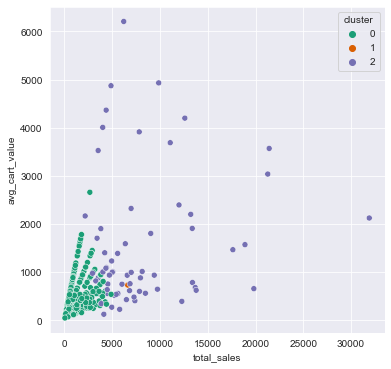

In [29]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=pca_df, x='total_sales', y='avg_cart_value',
    hue= 'cluster',
    palette= 'Dark2')
plt.show()

## <span style="color:RoyalBlue">Exercise 5.5 - Model "Comparison"</span>

Great, now just as a recap, here's what we have so far:
1. Clusters created by only using purchase pattern features (saved in <code style="color:steelblue">base_df</code>)
2. Clusters created by using purchase pattern features **and** thresholded item data (saved in <code style="color:steelblue">threshold_df</code>)
3. Clusters created by using purchase pattern features **and** PCA item data (saved in <code style="color:steelblue">pca_df</code>)

Most importantly, each of those 3 dataframes have the same indices. Specifically, they each still have the **CustomerID's** as their indices. That means we can directly compare and constrast the clusters created from those 3 clustering approaches.

#### Again, it's worth repeating that there aren't any clear, widely-accepted *performance metrics* for clustering tasks because we don't have labeled "ground truth."
* For regression, you could calculate the error between your predictions and the true values.
* For classification, you could calculate the AUROC of your predictions and the true classes.
* For clustering, you don't know what's "true."

Therefore, it's usually more useful to just compare the clusters created by different approaches.

#### A.) First, import <code>adjusted_rand_score</code> from <code>sklearn.metrics</code>.
* The **adjusted Rand index** is a similarity measure between two clusterings. It essentially counts the observations that were assigned to the same or different clusters by two different clusterings. 
* Values close to 0.0 indicate random/independent clusters
* Values close to 1.0 indicate nearly identical clusters

In [22]:
from sklearn.metrics import adjusted_rand_score

#### B.) For example, display the adjusted Rand index between <code style="color:steelblue">base_df.cluster</code> and <code style="color:steelblue">threshold_df.cluster</code>.

In [23]:
adjusted_rand_score(threshold_df.cluster, base_df.cluster)

0.6021354951782343

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
0.60213549517823428
</pre>

Furthermore, the adjusted Rand index is **symmetric**, which means you can pass in the clusters in any order. (Go ahead and try it - run your answer to part (B) again, but this time swap the two inputs.)

#### C.) Next, display the adjusted Rand index between <code style="color:steelblue">base_df.cluster</code> and <code style="color:steelblue">pca_df.cluster</code>.
* Is it higher or lower than the one between <code style="color:steelblue">base_df.cluster</code> and <code style="color:steelblue">threshold_df.cluster</code>?
* Which clusters are more like the ones created from the the base dataframe?

In [30]:
adjusted_rand_score(pca_df.cluster, base_df.cluster)

0.863644541934068

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
0.042311307744307906
</pre>

#### D.) Finally, display the adjusted Rand index between <code style="color:steelblue">threshold_df.cluster</code> and <code style="color:steelblue">pca_df.cluster</code>.
* Based on your answers to part (C) and part (D), could you have anticipated this score?

In [31]:
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.5844474489625285

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
0.033220422032313936
</pre>

#### At this point, as weird as it may feel, there's actually not much more you would do independently.
* You've created several alternatives and compared them, but the next step is usually bringing these alternatives to the client and seeing which one the client prefers.
* Often, you'll need to iterate and make tweaks. For example, you may decide that the better approach is to use PCA features, but only keep 10-20 instead of 125 (just so they don't dominate the algorithm relative to the base features).
* Or, the client may even ask you to create 9 clusters instead of 3.

The key is that you've seen the **major tools** that go into a successful cluster analysis. 


#### Just remember these 5 tips, and you'll be fine:
1. Keep your algorithm simple.
2. Only input relevant features.
3. Standardize your features before clustering.
4. Try different sets of features and compare the clusters created.
5. Communicate proactively with the key stakeholder!